# Vision Transformer

In this notebook we're gonna implement a vision transformer architecture, and see how it works

No time to waste, let's dig in!


[Here is](https://github.com/lucidrains/vit-pytorch) the github page with transformers implementations.

We're going to concentrate on the vanilla version as described [here](https://arxiv.org/abs/2010.11929)

# Task 1. Multi-Head Attention

<img src="https://data-science-blog.com/wp-content/uploads/2022/01/mha_img_original.png" style="width:50%">

In [ ]:
import torch

from torch import nn
from einops import rearrange  # hint


class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embed_dim: int, num_heads: int, dropout: float = 0.0) -> None:
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        assert embed_dim % num_heads == 0

        self.in_proj = None  # YOUR_CODE
        self.out_proj = None  # YOUR_CODE

        self.norm_coeff = self.head_dim ** 0.5

        self.attention_dropout = nn.Dropout(dropout)

    def forward(self, qkv: torch.Tensor) -> torch.Tensor:
        pass  # YOUR_CODE

Check it's the same as one implemented in `torch`

In [ ]:
mha = torch.nn.MultiheadAttention(embed_dim=128, num_heads=16, batch_first=True)
custom_mha = MultiHeadSelfAttention(embed_dim=128, num_heads=16)
custom_mha.in_proj.weight = mha.in_proj_weight
custom_mha.in_proj.bias = mha.in_proj_bias
custom_mha.out_proj.weight = mha.out_proj.weight
custom_mha.out_proj.bias = mha.out_proj.bias


with torch.no_grad():
  for _ in range(100):
      a = torch.rand((1, 10, 128))
      out1 = mha(a, a, a)[0]
      out2 = custom_mha(a)
      assert torch.allclose(out1, out2, atol=1e-5), f"{out1} {out2}"

print ("Seems fine!")

Next, we're going to implement `PatchEmbed` module which transforms your image into a sequence of tokens

In [ ]:
class PatchEmbed(nn.Module):
    def __init__(
        self, img_size: int, patch_size: int, dim: int, in_channels: int = 3
    ) -> None:
        super().__init__()
        assert (
            img_size % patch_size == 0
        ), "Image dimensions must be divisible by the patch size."
        self.img_size = img_size
        self.patch_size = patch_size
        self.dim = dim

        self.proj = nn.Conv2d(
            in_channels, dim, kernel_size=patch_size, stride=patch_size
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: [B, C, H, W] -> [num_patches, B, dim]
        return None  # YOUR CODE

Next one is . We are going to implement a version with trainable embeds

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, seq_len: int, dim: int) -> None:
        super().__init__()
        self.seq_len = seq_len
        self.dim = dim

        self.pe = nn.Parameter(torch.randn(seq_len, 1, dim), requires_grad=True)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: [num_patches, B, dim] -> [num_patches, B, dim]
        return None  # YOUR CODE

The final parts of our transformer

In [ ]:
class ClassificationHead(nn.Module):
    def __init__(self, d_model: int, hidden: int, num_classes: int) -> None:
        super().__init__()
        self.d_model = d_model
        self.hidden = hidden
        self.num_classes = num_classes

        self.mlp = nn.Sequential(
            nn.Linear(d_model, hidden), nn.SiLU(), nn.Linear(hidden, num_classes)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: [B, d_model] -> [B, num_classes]
        return self.mlp(x)


class MLP(nn.Module):
    def __init__(self, dim: int, hidden: int, dropout: float = 0.1) -> None:
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fc1 = nn.Linear(dim, hidden)
        self.fc2 = nn.Linear(hidden, dim)
        self.act = nn.SiLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: [num_patches, B, dim] -> [num_patches, B, dim]
        x = self.norm(x)
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return x


class TransformerBlock(nn.Module):
    def __init__(self, d_model: int, mlp_hidden: int, num_heads: int) -> None:
        super().__init__()
        self.attn = MultiHeadSelfAttention(num_heads, d_model)
        self.mlp = MLP(d_model, mlp_hidden)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: [num_patches, B, d_model] -> [num_patches, B, d_model]
        x = x + self.attn(x)
        x = x + self.mlp(x)
        return x


class VisionTransformer(nn.Module):
    def __init__(
        self,
        img_size: int = 384,
        patch_size: int = 16,
        in_channels: int = 3,
        num_classes: int = 10,
        d_model: int = 256,
        num_heads: int = 8,
        mlp_hidden: int = 256,
        num_layers: int = 10,
    ) -> None:
        super().__init__()
        self.patch_embed = PatchEmbed(img_size, patch_size, d_model, in_channels)
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))
        self.pos_encoding = PositionalEncoding(
            None, d_model
        )

        self.transformer = nn.Sequential(
            *[
                TransformerBlock(d_model, mlp_hidden, num_heads)
                for _ in range(num_layers)
            ]
        )
        self.cls_head = ClassificationHead(d_model, mlp_hidden, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: [B, C, H, W] -> [B, num_classes]
        return None  # YOUR CODE

Check it works

In [45]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"{device=}")
transformer = VisionTransformer(img_size=28, patch_size=7, in_channels=1, d_model=64, num_heads=4, num_layers=3, mlp_hidden=64)
transformer = transformer.to(device)

device=device(type='cuda')


In [46]:
out = transformer(torch.randn(2, 1, 28, 28).to(device))
print(f"{out.shape=}")

out.shape=torch.Size([2, 10])


Let's test it works with a simple task: MNIST

In [47]:
from torchvision.datasets import FashionMNIST
from torchvision import transforms

In [48]:
train_data = FashionMNIST("./", train=True, transform=transforms.Compose([transforms.ToTensor()]), download=True)
val_data = FashionMNIST("./", train=False, transform=transforms.Compose([transforms.ToTensor()]), download=True)

In [49]:
from tqdm.notebook import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt

def train(transformer, optimizer, train_loader, val_loader, criterion, num_epochs):
  transformer.train()
  device = next(transformer.parameters()).device
  train_hist = []
  val_hist = []
  val_acc = []
  for epoch in range(num_epochs):

    transformer.train()

    for images, labels in tqdm(train_loader):
      optimizer.zero_grad()
      images, labels = images.to(device), labels.to(device)
      logits = transformer(images)
      loss = criterion(logits, labels)
      loss.backward()
      optimizer.step()
      train_hist.append(loss.item())

    transformer.eval()
    with torch.no_grad():
      acc = 0
      for images, labels in tqdm(val_loader):
        images, labels = images.to(device), labels.to(device)
        logits = transformer(images)
        acc += (logits.argmax(dim=1) == labels).sum()
        loss = criterion(logits, labels)
        val_hist.append(loss.item())
      val_acc.append((acc / len(val_loader.dataset)).cpu())

    clear_output()
    _, axes = plt.subplots(1, 2, figsize=(12, 8))
    axes = axes.flatten()
    axes[0].plot(train_hist, label="train")
    axes[0].plot(val_hist, label="val")
    axes[1].plot(val_acc, label="val")
    axes[0].legend()
    axes[1].legend()

    plt.show()
  return train_hist, val_hist, val_acc

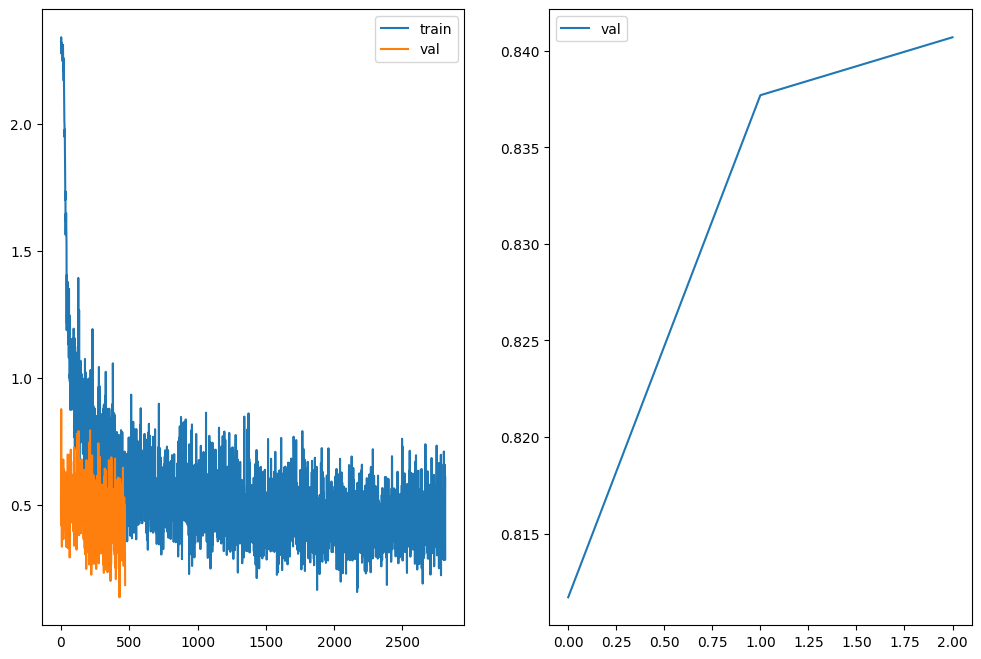

In [50]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=64, shuffle=True)

optimizer = torch.optim.AdamW(transformer.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

train_hist, val_hist, val_acc = train(transformer, optimizer, train_loader, val_loader, criterion, 3)

#### Next:

Try to train this model on cifar-10

you can use default parameters. They are a good start.

Also you might wanna utilize scheduler. Transformers benefit a lot from schedulers.

If everything is done correctly, you'll get around 0.9 accuracy